In [1]:
import pyarrow.dataset as ds
import pyarrow.parquet as pq
import pandas as pd

base_path = "/home/hygo2025/Documents/data/processed_data/enriched_events_vix"



In [2]:
dataset = ds.dataset(base_path, format="parquet", partitioning="hive")
table = dataset.to_table()
df_vix = table.to_pandas()

print(df_vix.shape)
print(df_vix.columns.tolist())
df_vix.head()


(14519740, 22)
['listing_id', 'user_id', 'session_id', 'event_type', 'price', 'event_ts', 'event_id', 'platform', 'business_type', 'neighborhood', 'zip_code', 'usable_areas', 'total_areas', 'bathrooms', 'bedrooms', 'suites', 'parking_spaces', 'amenities', 'unit_type', 'usage_type', 'geopoint', 'dt']


,listing_id,user_id,session_id,event_type,price,event_ts,event_id,platform,business_type,neighborhood,...,total_areas,bathrooms,bedrooms,suites,parking_spaces,amenities,unit_type,usage_type,geopoint,dt
0,395548,21322,1697,RankingRendered,300000.0,2024-04-17 12:25:08.740,ranking-rendered-9999e6,DESKTOP,SALE,balneário ponta da fruta,...,70.0,2.0,2.0,0.0,1.0,"['KITCHEN', 'KITCHEN_CABINETS', 'SERVICE_AREA'...",HOME,RESIDENTIAL,"-40.3747719,-20.5101708",2024-04-18
1,358437,21322,1697,RankingRendered,540750.0,2024-04-17 12:25:08.740,ranking-rendered-9999e6,DESKTOP,SALE,praia de itaparica,...,60.0,2.0,2.0,1.0,2.0,"['KITCHEN', 'BALCONY', 'KITCHEN_CABINETS', 'BA...",APARTMENT,RESIDENTIAL,"-40.3022484,-20.3709523",2024-04-18
2,268831,21322,1697,RankingRendered,1250000.0,2024-04-17 12:25:08.740,ranking-rendered-9999e6,DESKTOP,SALE,barra do jucu,...,300.0,4.0,3.0,3.0,4.0,[],HOME,RESIDENTIAL,"-40.3251852,-20.4285117",2024-04-18
3,444009,21322,1697,RankingRendered,670000.0,2024-04-17 12:25:08.740,ranking-rendered-9999e6,DESKTOP,SALE,itapuã,...,80.0,2.0,2.0,1.0,0.0,[],APARTMENT,RESIDENTIAL,"-40.2896807,-20.3522924",2024-04-18
4,485278,21322,1697,RankingRendered,3500.0,2024-04-17 12:23:41.797,ranking-rendered-7qkl5o,DESKTOP,RENTAL,itapuã,...,64.0,1.0,2.0,0.0,1.0,"['POOL', 'SAUNA']",APARTMENT,RESIDENTIAL,"-40.2896807,-20.3522924",2024-04-18


In [3]:
df_vix.columns

Index(['listing_id', 'user_id', 'session_id', 'event_type', 'price',
       'event_ts', 'event_id', 'platform', 'business_type', 'neighborhood',
       'zip_code', 'usable_areas', 'total_areas', 'bathrooms', 'bedrooms',
       'suites', 'parking_spaces', 'amenities', 'unit_type', 'usage_type',
       'geopoint', 'dt'],
      dtype='object')

### Análise Exploratória de Dados (EDA)

In [4]:
unique_listings = df_vix["listing_id"].nunique()
unique_listings

67541

In [5]:
unique_users = df_vix["user_id"].nunique()
unique_users

79491

In [6]:
unique_events = df_vix["event_type"].nunique()
unique_events

9

In [7]:
unique_neighborhoods = df_vix["neighborhood"].nunique()
unique_neighborhoods

88

In [8]:
# Quantidade de eventos por bairro
events_per_neighborhood = df_vix.groupby("neighborhood").size().reset_index(name='event_count').sort_values(by='event_count', ascending=False)
events_per_neighborhood.head(10)

,neighborhood,event_count
58,praia da costa,3911598
60,praia de itaparica,3067312
32,itapuã,2299759
18,coqueiral de itaparica,508532
41,jockey de itaparica,482163
13,centro de vila velha,388982
59,praia das gaivotas,374967
5,ataíde,306407
31,interlagos,207282
21,divino espírito santo,197894


In [9]:
events_by_type_and_neighborhood = (
    df_vix
    .groupby(["neighborhood", "event_type"])
    .size()
    .reset_index(name="event_count")
    .pivot_table(
        index="neighborhood",
        columns="event_type",
        values="event_count",
        fill_value=0
    )
)

events_by_type_and_neighborhood["total_events"] = events_by_type_and_neighborhood.sum(axis=1)
events_by_type_and_neighborhood = events_by_type_and_neighborhood.sort_values("total_events", ascending=False)

events_by_type_and_neighborhood = events_by_type_and_neighborhood.reset_index()
events_by_type_and_neighborhood.head(10)

event_type,neighborhood,DecisionTreeFormClicked,FavoriteClicked,GalleryClicked,LeadClicked,LeadPanelClicked,ListingRendered,RankingClicked,RankingRendered,ShareClicked,total_events
0,praia da costa,3223.0,11922.0,1287982.0,8776.0,3147.0,125185.0,77799.0,2391623.0,1941.0,3911598.0
1,praia de itaparica,2223.0,10722.0,1032160.0,7472.0,2978.0,97979.0,58563.0,1853579.0,1636.0,3067312.0
2,itapuã,2235.0,7734.0,770682.0,6616.0,2492.0,77365.0,45303.0,1386003.0,1329.0,2299759.0
3,coqueiral de itaparica,800.0,1494.0,158137.0,1873.0,660.0,16583.0,9099.0,319637.0,249.0,508532.0
4,jockey de itaparica,540.0,1757.0,158094.0,1702.0,588.0,18262.0,10494.0,290402.0,324.0,482163.0
5,centro de vila velha,343.0,990.0,105043.0,943.0,453.0,11815.0,6931.0,262302.0,162.0,388982.0
6,praia das gaivotas,544.0,1333.0,130635.0,1429.0,452.0,13930.0,8340.0,218047.0,257.0,374967.0
7,ataíde,363.0,1085.0,84883.0,1005.0,362.0,10318.0,5801.0,202424.0,166.0,306407.0
8,interlagos,89.0,697.0,57793.0,323.0,124.0,6164.0,3946.0,138071.0,75.0,207282.0
9,divino espírito santo,231.0,406.0,48598.0,554.0,211.0,4468.0,2487.0,140876.0,63.0,197894.0


In [10]:
cols = ['listing_id', 'price', 'usable_areas', 'total_areas',
        'bathrooms', 'bedrooms', 'suites', 'parking_spaces', 'business_type']

df_num = df_vix[cols]

df_num = (
    df_vix.groupby('listing_id')
    .agg({
        'price': 'mean',          # média de preço
        'usable_areas': 'first',
        'total_areas': 'first',
        'bathrooms': 'first',
        'bedrooms': 'first',
        'suites': 'first',
        'parking_spaces': 'first',
        'business_type': 'first'
    })
    .reset_index()
)

df_num.sort_values('listing_id', ascending=True).head(10)


,listing_id,price,usable_areas,total_areas,bathrooms,bedrooms,suites,parking_spaces,business_type
0,16,1780000.0,155.0,155.0,2.0,4.0,0.0,2.0,SALE
1,25,1270000.0,150.0,NaN,3.0,4.0,1.0,2.0,SALE
2,32,750000.0,148.0,NaN,2.0,3.0,1.0,2.0,SALE
3,36,1700000.0,230.0,230.0,5.0,5.0,0.0,2.0,SALE
4,65,1900.0,90.0,90.0,1.0,3.0,1.0,1.0,RENTAL
5,79,385000.0,65.0,65.0,1.0,2.0,0.0,1.0,SALE
6,89,185000.0,82.0,189.0,1.0,2.0,0.0,1.0,SALE
7,121,2990000.0,220.0,220.0,5.0,4.0,3.0,3.0,SALE
8,135,285000.0,60.0,60.0,1.0,2.0,0.0,1.0,SALE
9,155,5950000.0,600.0,600.0,7.0,6.0,5.0,4.0,SALE


In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator, FuncFormatter

def plot_distribution(df, column, category_col=None, category_val=None, bins=100):
    data = df.copy()
    if category_col and category_val:
        data = data[data[category_col] == category_val]

    data = data[data[column].notnull() & (data[column] > 0)]
    fig, axs = plt.subplots(1, 2, figsize=(18, 6))

    sns.histplot(data=data, x=column, kde=True, bins=bins, ax=axs[0])
    axs[0].set_title(f'Distribuição de {column} (Escala Normal)', fontsize=13)
    axs[0].set_xlabel(column)
    axs[0].set_ylabel('Frequência')

    sns.histplot(data=data, x=column, kde=True, bins=bins, log_scale=True, ax=axs[1])
    axs[1].set_title(f'Distribuição de {column} (Escala Logarítmica)', fontsize=13)
    axs[1].set_xlabel(column)
    axs[1].set_ylabel('Frequência')

    axs[1].xaxis.set_major_locator(LogLocator(base=10.0))
    axs[1].xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x):,}'))

    plt.tight_layout()
    plt.show()


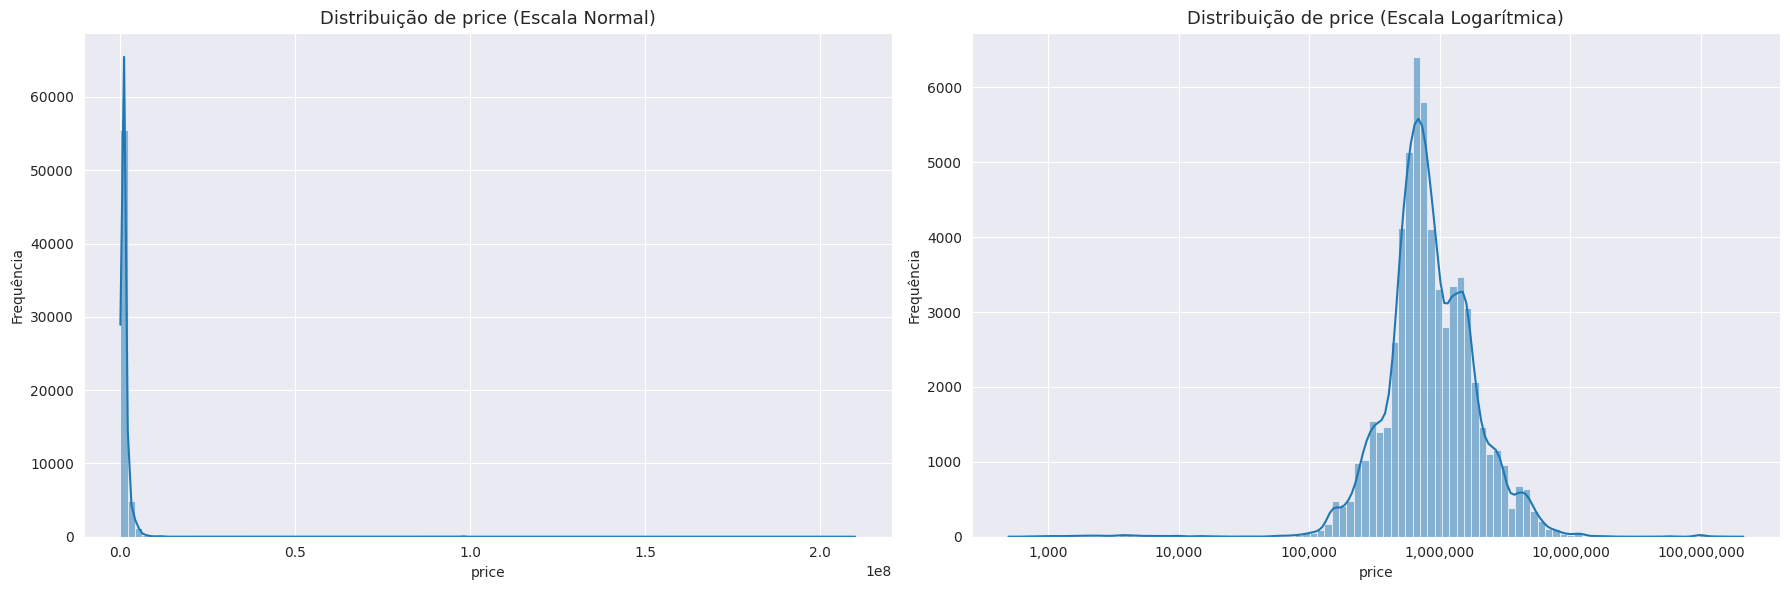

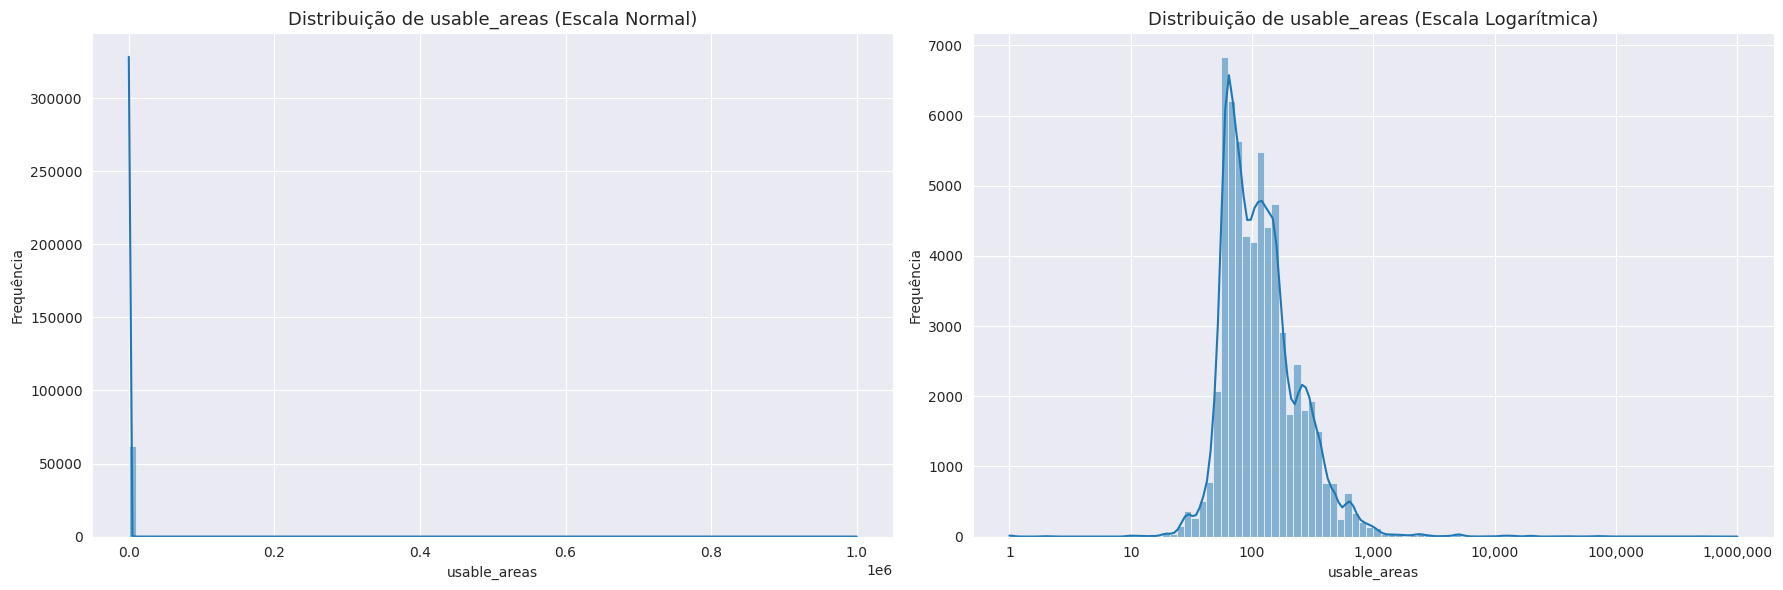

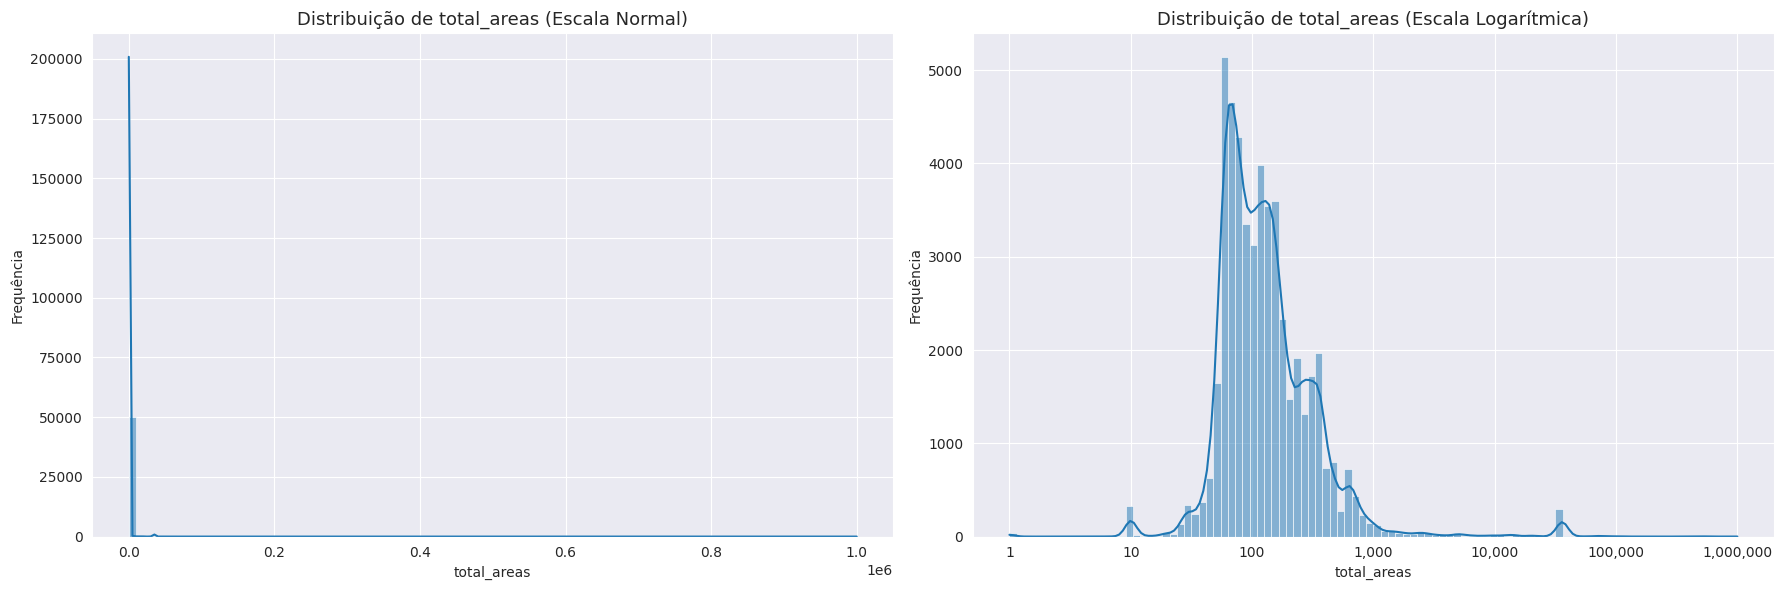

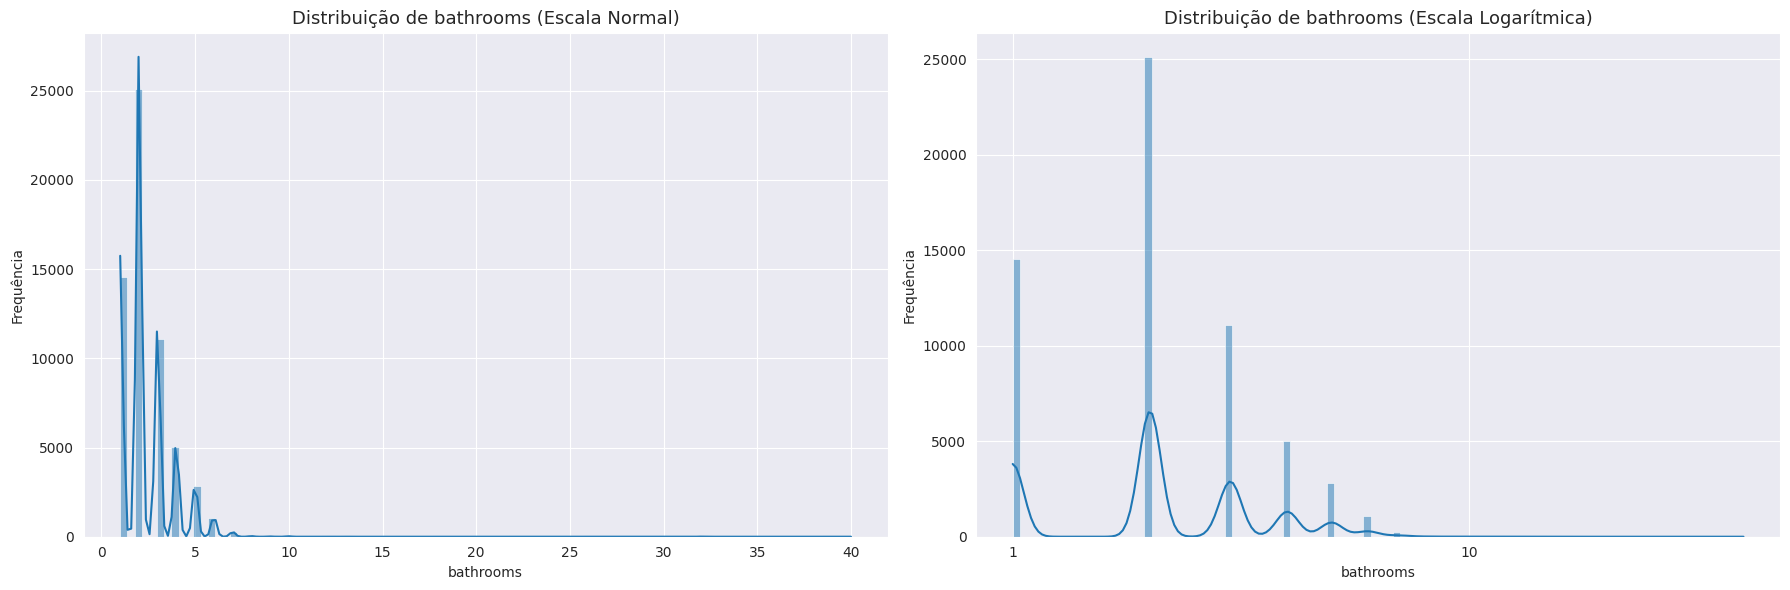

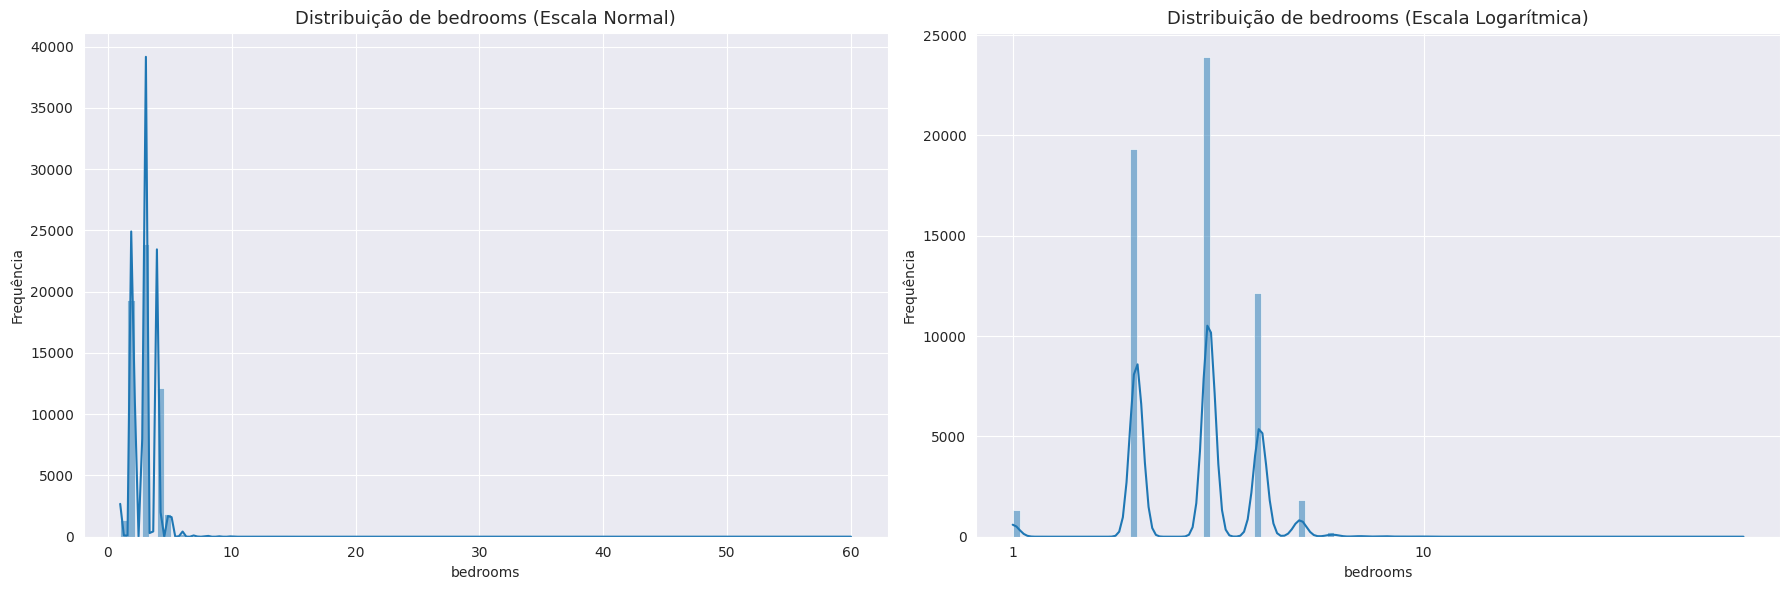

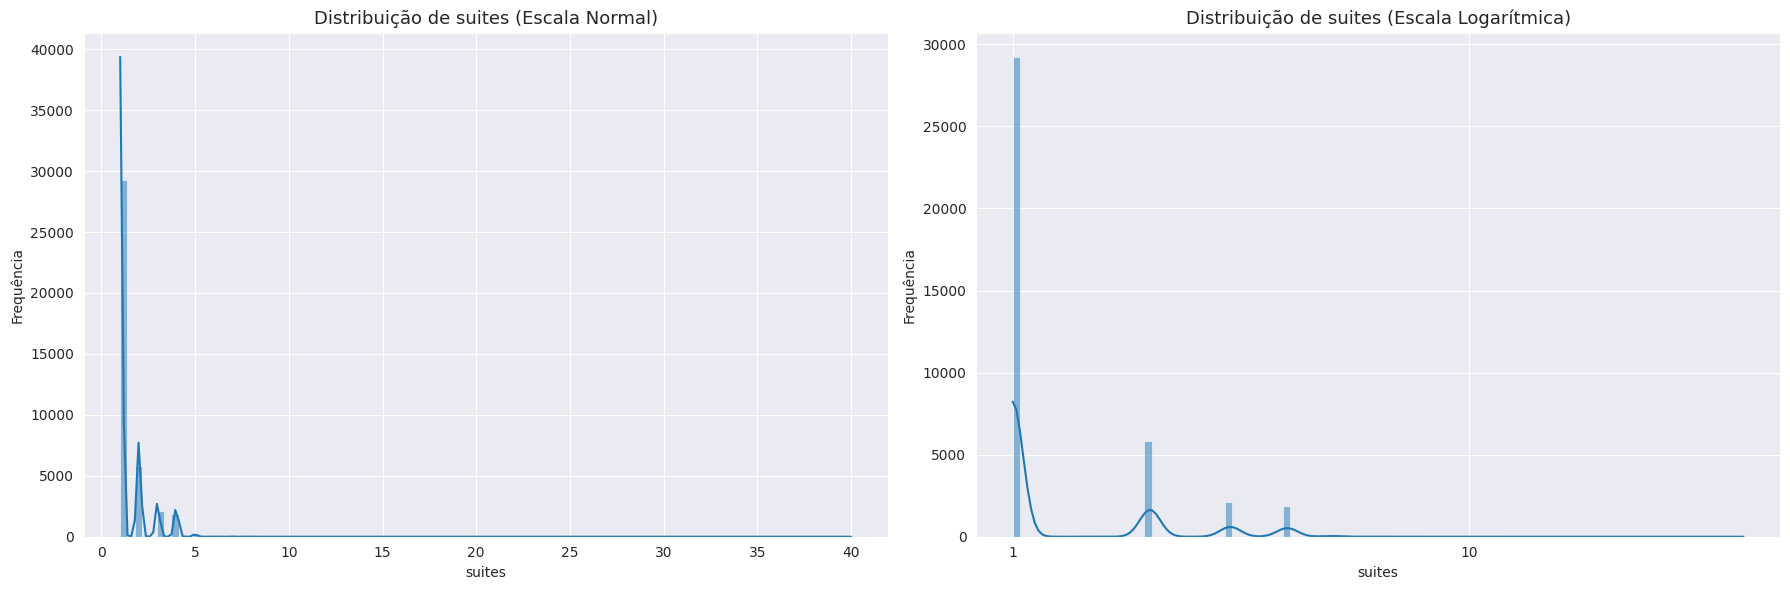

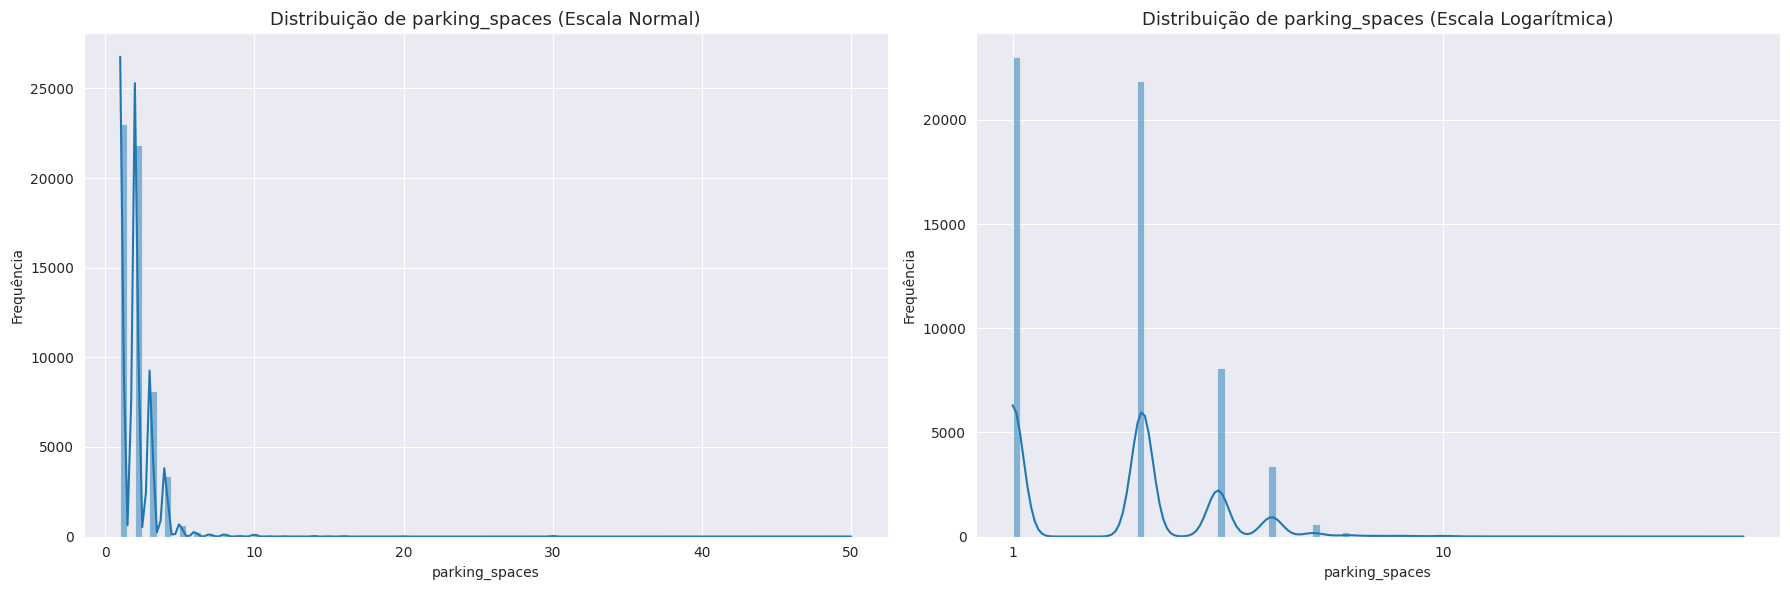

In [12]:
cols = ['price', 'usable_areas', 'total_areas', 'bathrooms', 'bedrooms', 'suites', 'parking_spaces']

for col in cols:
    plot_distribution(df_num, column=col, category_col='business_type', category_val='SALE')


In [13]:
df_feat_caract = df_num[['bedrooms', 'bathrooms' , 'parking_spaces', 'total_areas', 'usable_areas']].copy()
df_feat_caract.describe().apply(lambda s: s.apply('{0:.5f}'.format))

,bedrooms,bathrooms,parking_spaces,total_areas,usable_areas
count,67132.00000,67256.00000,65281.00000,55559.00000,67485.00000
mean,2.72070,2.24979,1.89331,566.18992,266.54753
std,1.24200,1.34381,1.66830,8175.02727,6358.70066
min,0.00000,0.00000,0.00000,1.00000,0.00000
25%,2.00000,1.00000,1.00000,70.00000,68.00000
50%,3.00000,2.00000,2.00000,110.00000,103.00000
75%,3.00000,3.00000,2.00000,188.50000,168.00000
max,60.00000,40.00000,100.00000,1000000.00000,1000000.00000


<Axes: xlabel='usable_areas'>

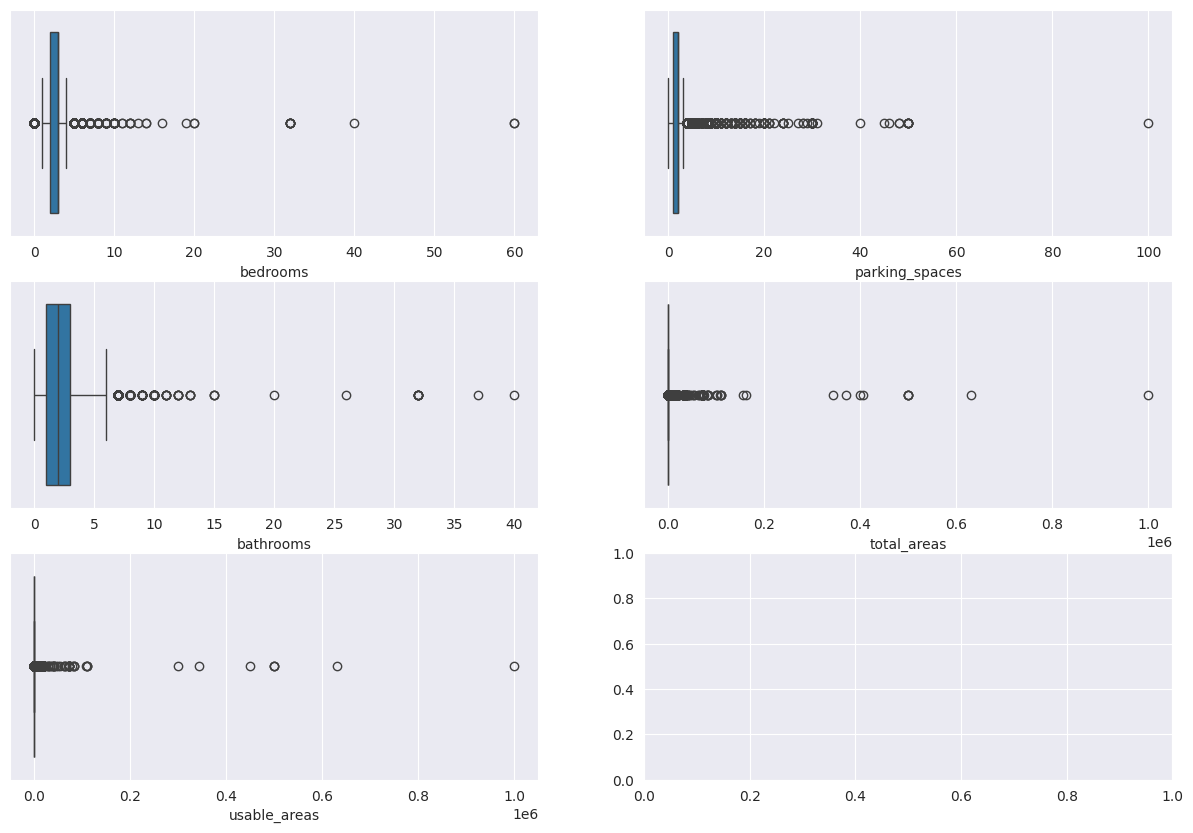

In [14]:
fig, axs = plt.subplots(3, 2, figsize=(15, 10))#, sharey=True)

sns.boxplot(x=df_feat_caract["bedrooms"], ax=axs[0, 0])
sns.boxplot(x=df_feat_caract["bathrooms"], ax=axs[1, 0])
sns.boxplot(x=df_feat_caract["parking_spaces"], ax=axs[0, 1])
sns.boxplot(x=df_feat_caract["total_areas"], ax=axs[1, 1])
sns.boxplot(x=df_feat_caract["usable_areas"], ax=axs[2, 0])

In [15]:
df_feat_caract.nunique()

bedrooms           21
bathrooms          20
parking_spaces     36
total_areas       871
usable_areas      810
dtype: int64